# Model

After defining the features to use, models will now be fitted to the data and feature selection will be performed based on performance against the validation dataset witheld earlier.

Two classical models are considered - logistic regression and decision tree classifier.

## Scoring metric

Models are scored against the *area under the reciever operator characteristic curve* (`auc`).

The *reciever operator characteristic curve* is the trade-off between *sensitivity* and *specificity* as the minimum threshold for prediction changes. It is a useful measure of the performance of the model across a range of use cases. A better model will have a larger area under this curve, meaning that for a given sensitivity level a better specificity can be achieved.

## Pre-processing

### Rate features

Rates (eg count of some event) are always positive or zero. We are dividing this by another value which is always positive or zero, the time elapsed. The resulting distribution is also positive or zero where defined and may have some extreme values in cases where the elapsed time is very small.

To account for this, I introduced a "calibration period" where we discard the first `minimum_observations` rows and the `minimum_elapsed_time_hours` of sensor observations, so that our calculated event rate is more stable.

In logistic regression, it is also assumed that the features are normally distributed. Our rate features will not be normally distributed, but to keep this analysis simple they are approximately standardised by removing the mean and scaling to unit variance. Note that we get the sample mean and variance using training data only to avoid any leakage of information from the test or validation sets.

### Proportion features

Proportion features (eg a count of a particular event divided by count of all events) will also be always positive or zero. The examples used in this analysis will always be defined, as predictions are only performed when there has been at least one sensor event.

Again proportion features will not have a normal distribution but to keep the analysis simple we also standardise these before performing logistic regression.

### Fake features

Noise variables are added to the feature set to help guage if the model is over-fitting to the training data as there should be no relationship between the noise variables and the response.

## Feature selection

I decided to use forward stepwise feature selection. The algorithm is as follows:

```
* begin with no features and minimum model score (0.5 for AUC) equivalent to guessing at random.
* while there are remaining features:
    * for each remaining feature:
        * create a new model including the feature
        * evaluate unseen performance of new model with cross-validation
    * find feature providing best new model
    * if adding this feature improved out of sample performance on average by more than 1%, we include it in the model and remove it from remaining features
    * if no improvement in the model from adding any feature, break
```

While this is not guaranteed to find the optimal set of features, it is easily parallelised and simple to implement.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from lib.common.paths import DATABASE_LOCATION
from lib.data.features import add_all_features, read_raw_data
from lib.model.fit import add_fake_features, post_warmup_locator, rebalance_classes
from lib.model.stepwise import StepwiseFeatureSelector

response = "multiple_occupancy"
multi_location_windows = ["5min", "30min", "1h", "2h"]

df_train = add_all_features(read_raw_data(DATABASE_LOCATION, train=True), multi_location_windows)
# oversample under-represented class to balance training data
df_train = rebalance_classes(df_train, response)
df_valid = add_all_features(read_raw_data(DATABASE_LOCATION, valid=True), multi_location_windows)

multi_room_features = [f"multiple_room_triggers_{window}_per_hour" for window in multi_location_windows]
event_rate_features = ["total_all_locations_per_hour"]
bathroom_features = ["bathroom_proportion"]
all_features = multi_room_features + event_rate_features + bathroom_features
missing_features = list(set(all_features) - set(df_train.columns))
assert len(missing_features) < 1

# add noise variables to help guage feature selection method
n_fake_features = len(all_features) // 2
df_train, fake_feature_names = add_fake_features(df_train, n_fake_features)
df_valid, _ = add_fake_features(df_valid, n_fake_features)

total_features = all_features + fake_feature_names
print(f"Using features\n{total_features}")

# introduce warmup period
minimum_observations = 5
minimum_elapsed_time_hours = 1.0

train_locator = post_warmup_locator(df_train, minimum_observations, minimum_elapsed_time_hours)
X = df_train.loc[train_locator, total_features].values.astype(np.float64)
y = df_train.loc[train_locator, response].values.astype(np.float64)

valid_locator = post_warmup_locator(df_valid, minimum_observations, minimum_elapsed_time_hours)
X_valid = df_valid.loc[valid_locator, total_features].values.astype(np.float64)
y_valid = df_valid.loc[valid_locator, response].values.astype(np.float64)

Using features
['multiple_room_triggers_5min_per_hour', 'multiple_room_triggers_30min_per_hour', 'multiple_room_triggers_1h_per_hour', 'multiple_room_triggers_2h_per_hour', 'total_all_locations_per_hour', 'bathroom_proportion', 'fake_0', 'fake_1', 'fake_2']


## Model Fitting

Scikit-Learn's model pipeline provides a clean abstraction over the pre-processing, fitting and prediction stages of a relatively simple machine learning model. In addition, it is well integrated with ONNX via `skl2onnx` package.

Three model parameterizations are tested:

| Model Name | Type                     | Configuration                                                     |   |   |
|------------|--------------------------|-------------------------------------------------------------------|---|---|
| lr         | Logistic Regression      | Input data standardized with SKlearn StandardSclaler              |   |   |
| dt_shallow | Decision Tree Classifier | Maximum tree depth: 2, Minimum number of samples per leaf: 40,000 |   |   |
| dt_deep    | Decision Tree Classifier | Maximum tree depth: 4, Minimum number of samples per leaf: 40,000 |   |   |




~~~~~~~~~~
Pipeline: lr


2024-05-06 13:12:53,885 - INFO - Selected 5 with best score of 0.5871013749412974
2024-05-06 13:12:59,505 - INFO - Selected 4 with best score of 0.6106839106219172
2024-05-06 13:13:04,393 - INFO - Finishing as selection best score 0.614was not better than existing model 0.611
2024-05-06 13:13:04,394 - INFO - Selected features: [5, 4]


unseen AUC ROC: 0.6790953395946742

~~~~~~~~~~
Pipeline: dt_shallow


2024-05-06 13:13:09,661 - INFO - Selected 4 with best score of 0.7493089855948419
2024-05-06 13:13:16,523 - INFO - Selected 5 with best score of 0.7805763391343548
2024-05-06 13:13:24,668 - INFO - Finishing as selection best score 0.781was not better than existing model 0.781
2024-05-06 13:13:24,669 - INFO - Selected features: [4, 5]


unseen AUC ROC: 0.7871002609224148

~~~~~~~~~~
Pipeline: dt_deep


2024-05-06 13:13:33,785 - INFO - Selected 4 with best score of 0.8532787177248122
2024-05-06 13:13:46,043 - INFO - Selected 5 with best score of 0.9454473071143313
2024-05-06 13:14:00,693 - INFO - Finishing as selection best score 0.946was not better than existing model 0.945
2024-05-06 13:14:00,694 - INFO - Selected features: [4, 5]


unseen AUC ROC: 0.7797319226597278


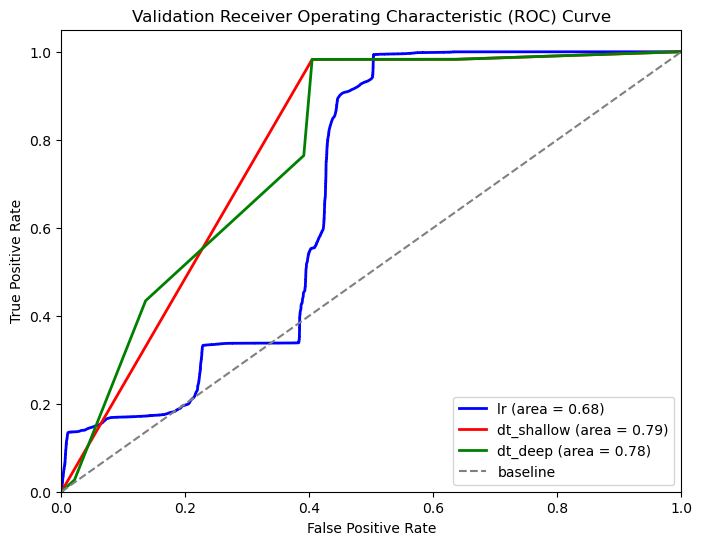

In [2]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

min_improvement_r = 0.01

pipelines = {
    "lr": Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("feature_selector", StepwiseFeatureSelector(estimator=LogisticRegression(), min_improvement_r=min_improvement_r)),
            ("classifier", LogisticRegression()),
        ]
    ),
    "dt_shallow": Pipeline(
        [
            (
                "feature_selector",
                StepwiseFeatureSelector(estimator=DecisionTreeClassifier(max_depth=2), min_improvement_r=min_improvement_r),
            ),
            ("classifier", DecisionTreeClassifier(max_depth=2, min_samples_leaf=40000)),
        ]
    ),
    "dt_deep": Pipeline(
        [
            (
                "feature_selector",
                StepwiseFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4), min_improvement_r=min_improvement_r),
            ),
            ("classifier", DecisionTreeClassifier(max_depth=4, min_samples_leaf=40000)),
        ]
    ),
}

cmap = {
    "lr": "blue",
    "dt_shallow": "red",
    "dt_deep": "green"
}

fig, ax = plt.subplots(1,1,figsize=(8,6))

for pipeline_name, pipeline in pipelines.items():
    print(f"\n{'~'*10}")
    print(f"Pipeline: {pipeline_name}")
    pipeline.fit(X, y)
    y_valid_pred = pipeline.predict_proba(X_valid.astype(np.float64))[:, 1]
    roc = roc_auc_score(y_valid, y_valid_pred)
    print(f"unseen AUC ROC: {roc}")

    fpr, tpr, _ = roc_curve(y_valid, y_valid_pred)
    
    ax.plot(fpr, tpr, color=cmap[pipeline_name], lw=2, label='%s (area = %0.2f)' % (pipeline_name, roc))
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label="baseline")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Validation Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

## Analysis

### Over-fitting

The deeper decision tree `dt_deep` had very high performance on the training set but slightly poorer performance on the unseen data in the validation set than the shallow tree, `dt_shallow`.

Logistic regression `lr` had robust performance on unseen data, but overall had a lower AUC in both train and test sets than the `dt_shallow` model, likely due to not being able to capture a non-linear relationship between `total_all_locations_per_hour` and the response.

### Feature Selection

All models picked features 4 `total_all_locations_per_hour` and 5 `bathroom_proportion`, showing that these had the most significant relationship with the response variable. Since no noise variables were selected, it seems like the stepwise feature selection algorithm worked as expected.

I did set the `min_improvement_r` to 1% which may have been quite aggressive - a new feature would only be considered if it improved the best model's score by more than 1%. There are more advanced ways to perform this test which could be explored in the future, such as a pairwise statistical test between the current best model and a candidate model across the k-fold splits.

### Feature Relationships

The shallow decision tree captured some non-linear behaviour in the `total_all_locations_per_hour` feature, which was not possible to capture with logistic regression.

As shown in the decision tree plot below, homes with the highest number of total motion triggers per hour were more likely to be single-occupant homes. One hypothesis here is that homes with multiple occupants may leave the home more often for social activities, whereas an individual living alone may spend more time at home, especially if they are have a disability of some kind and depend on others for transport.

The next split was in the `bathroom_proportion` feature. This aligned with the hypothesis drawn when creating this feature - multiple occupant homes have a higher proportion of events take place in the bathroom.

The logistic regression coefficients also confirmed these relationships, with coefficients for `total_all_locations_per_hour` being negative and `bathroom_proportion` being positive.

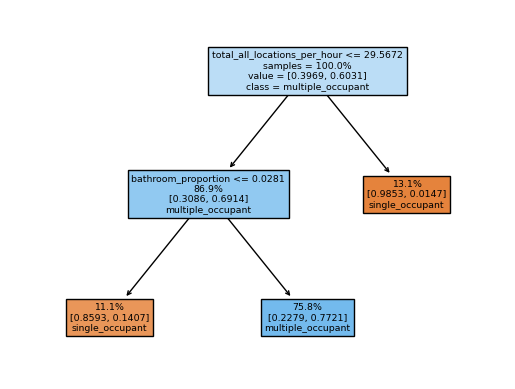

In [3]:
from sklearn.tree import plot_tree
pipeline = pipelines["dt_shallow"]

selected_features = [total_features[i] for i in pipeline["feature_selector"].selected_features_]
ax = plot_tree(pipeline["classifier"], feature_names=selected_features, class_names=["single_occupant", "multiple_occupant"],
               filled=True, impurity=False, precision=4, proportion=True, label="root")

Text(0.5, 1.0, 'Coefficients of Logistic Regression Model')

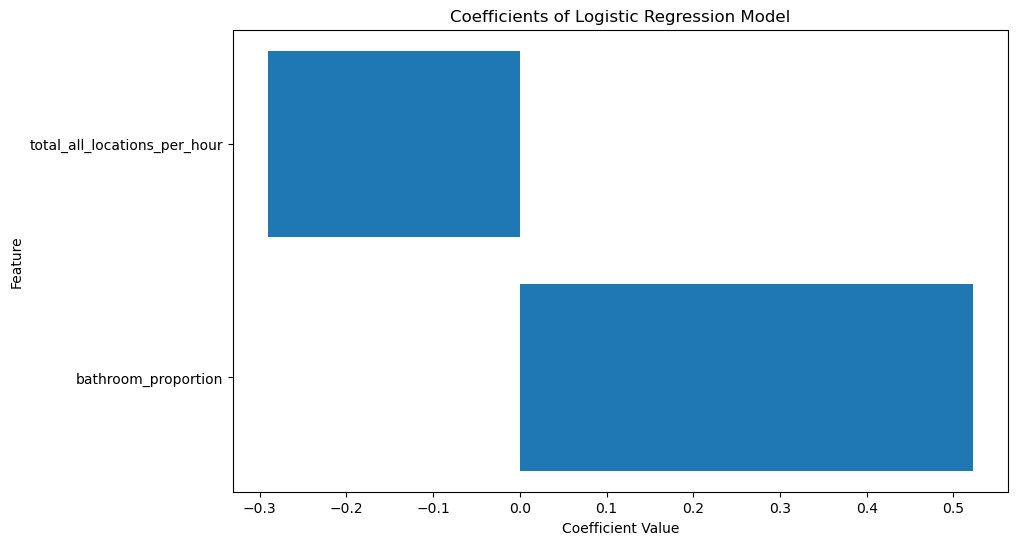

In [4]:
pipeline = pipelines["lr"]
coefficients = pipeline['classifier'].coef_
selected_features = [total_features[i] for i in pipeline["feature_selector"].selected_features_]

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.barh(range(len(coefficients[0])), coefficients[0], align='center')
ax.set_yticks(range(len(coefficients[0])), selected_features)
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Feature')
ax.set_title('Coefficients of Logistic Regression Model')